In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.autograd as ag
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
import time
from torchvision import models
import matplotlib.pyplot as plt

import ModelUtil
import ASDC_loader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#device = torch.device('cpu')


cuda


In [2]:
truncate_len = 192555
truncate_len = 160000
# truncate_len =  40000
train_range, val_range = ModelUtil.make_val_ranges(truncate_len, 4, 0)


crop_size = (254,254)
train_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='train', ID_idxs=train_range, truncate=truncate_len, crop=crop_size)
val_dataset = ASDC_loader.ASDC_Crop_Class_Dataset(dataset='validate', ID_idxs=val_range, truncate=truncate_len, crop=crop_size)

print('train:\t' + str(len(train_range)) +' images,\t'+ str(len(train_dataset))+ ' samples')
print('vali:\t' + str(len(val_range)) + ' images,\t'+ str(len(val_dataset))+ ' samples')

train:	120000 images,	144553 samples
vali:	40000 images,	47933 samples


In [3]:
def save_whole_checkpoint():
    ASDC_loader.save_checkpoint(param_path, 
                                model=model, 
                                optimizer=optimizer, 
                                epoch=epoch, 
                                idx=idx, 
                                B=B, 
                                losses=losses, 
                                train_accs=train_accs,
                                val_accs=val_accs)            

# Train classifier

In [4]:
class AlexNetFCN(nn.Module):
    ranges = ((0, 3), (3, 6), (6, 8), (8, 10), (10, 13))
    def __init__(self, num_classes=2):
        super(AlexNetFCN, self).__init__()
        self.num_classes = num_classes
        
        self.if_class = True
        self.ranges = AlexNetFCN.ranges
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=100), #conv1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.modules.normalization.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75),
            
            nn.Conv2d(96, 256, kernel_size=5, padding=2, groups=2), #conv2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
#             nn.modules.normalization.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75),
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1), #conv3
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 384, kernel_size=3, padding=1, groups=2), #conv4
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2), #conv5
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.fc = nn.Sequential( #fully convolutional
            
            nn.Conv2d(256, 4096, kernel_size=6), #fc6
            nn.ReLU(inplace=True),
            nn.Dropout(),
            
            
            nn.Conv2d(4096, 4096, kernel_size=1), #fc7
            nn.ReLU(inplace=True),
            nn.Dropout(),
            
            nn.Conv2d(4096, num_classes, kernel_size=1) #score_fr
        )
                
        self.classifier = nn.Sequential(
            nn.Dropout(),
#             nn.Conv2d(256 * 6 * 6, 4096,kernel_size=1),
            nn.Linear(256 * 13 * 13, 4096),
            nn.ReLU(inplace=True),
            
            nn.Dropout(),
#             nn.Conv2d(256 * 6 * 6, 4096,kernel_size=1),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, num_classes),
        )

        self.upscore = nn.ConvTranspose2d(num_classes, 
            num_classes, kernel_size=63, stride=32, padding=1, dilation=1, output_padding=0)
        
        
        #Initilize the parameters
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def initialize_fcn(self):
        for m in self.fc.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                print('conv init')
        for m in self.upscore.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data = nn.init.kaiming_normal(m.weight.data)
                print('deconv init')

    def forward(self, x):
        if self.if_class:
#             x = self.features(x)
#             x = self.fc(x)
#             return x.view(x.size(0),self.num_classes)
            x = self.features(x)
            x = x.view(x.size(0), 256 * 13 * 13)
            x = self.classifier(x)
            return x.view(x.size(0),self.num_classes)

        else: 
            shape = x.shape
            x = self.features(x)
            x = self.fc(x)
            x = self.upscore(x)
            x = x[:,:,:shape[2],:shape[3]] #crop
            x = F.softmax(x, dim=1)
            return x
 

    def remove_classifier(self):
#         del self.classifier
        self.if_class = False

In [5]:
model = AlexNetFCN(num_classes=2).to(device) 

In [6]:
N = len(train_dataset) # Training set size 
B = 8 # Minibacth size
NB = int(N/B) # Number of minibatches
T = 11 # Number of epochs
gamma = .005 # learning rate
rho = .9 # momentum

scheduler_period = 500 #units of batches

validate = True # eval training and validation error every epoch?
validate = False # eval training and validation error every epoch?

# Data loader (this provides queues and threads in a very simple way).
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                           num_workers=8)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=B, 
                                           shuffle=True,
                                           num_workers=8)

#test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=B)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)
print('done')

done


In [7]:
param_path = './alex_net_class_params.pt'

if not os.path.isfile(param_path):
    ModelUtil.save_checkpoint(param_path, model=model, optimizer=optimizer)
    print('using new model')
else:
    print('using local model')

checkpoint_dict = ModelUtil.load_checkpoint(param_path, model=model, optimizer=optimizer)


using local model


In [8]:
model.train()

last_time = time.time()
print('start time: %f' % time.time())

losses = [] if 'losses' not in checkpoint_dict else checkpoint_dict['losses']
train_accs = [] if 'train_accs' not in checkpoint_dict else checkpoint_dict['train_accs']
val_accs = [] if 'val_accs' not in checkpoint_dict else checkpoint_dict['val_accs']

epoch = 0
while epoch < T:
    if 'epoch' in checkpoint_dict and epoch <= checkpoint_dict['epoch']:
        epoch += 1
        continue
    running_loss = 0.0
    scheduler_running_loss = 0.0

    epoch_time = time.time()
    
    for idx, (images, labels) in enumerate(train_loader):        
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print averaged loss per minibatch every 100 mini-batches
        running_loss += loss.item() 
        if idx % 100 == 99:
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, idx + 1, running_loss/100))
            losses.append((epoch, idx, running_loss/100))
            scheduler_running_loss += running_loss
            running_loss = 0.0 
            if idx <= 500:
                print('sec per sample: {:f}'.format((time.time()-last_time)/(B*100)))#time_per_sample = (last_time-time.time())/(B*100)
                last_time = time.time()
        
        if idx % scheduler_period == scheduler_period-1:
            print('scheduler running loss: {:.5f}'.format(scheduler_running_loss/scheduler_period))
            scheduler.step(scheduler_running_loss/scheduler_period)
            scheduler_running_loss = 0.0

    
        # Release RAM
        #torch.cuda.empty_cache()    
    last_time = time.time()
    print('[{:03d} {:05d}] epoch took {:02f} secs to run'.format(epoch+1, idx+1, time.time()-epoch_time))
    
    if validate:
        #evaluate training accuracy
#         tmp_time = time.time()
#         train_acc = ModelUtil.eval_class_dataset(model, train_loader, device)
#         print('[{:03d} {:05d}] {:02f} secs to run \t training accuracy: {:04f}'.format(epoch+1, 
#                                                                                        idx+1, 
#                                                                                        time.time()-tmp_time, 
#                                                                                        train_acc))
#         train_accs.append((epoch, idx, train_acc))

        #evaluate validation accuracy
        tmp_time = time.time()
        val_acc = ModelUtil.eval_class_dataset(model, val_loader, device)
        print('[{:03d} {:05d}] {:02f} secs to run \t validati accuracy: {:04f}'.format(epoch+1, 
                                                                                       idx+1, 
                                                                                       time.time()-tmp_time, 
                                                                                       val_acc))
        val_accs.append((epoch, idx, val_acc))
    
    #done with one epoch
    save_whole_checkpoint()           
    print('saved at {:f}'.format(time.time()))
    
    epoch += 1
    
print('Finished Training')

start time: 1544798327.945244
[5,   100] loss: 0.146
sec per sample: 0.008612
[5,   200] loss: 0.129
sec per sample: 0.007626
[5,   300] loss: 0.157
sec per sample: 0.007651
[5,   400] loss: 0.140
sec per sample: 0.007621
[5,   500] loss: 0.171
sec per sample: 0.007643
scheduler running loss: 0.14846
[5,   600] loss: 0.147
[5,   700] loss: 0.130
[5,   800] loss: 0.141
[5,   900] loss: 0.140
[5,  1000] loss: 0.138
scheduler running loss: 0.13910
[5,  1100] loss: 0.140
[5,  1200] loss: 0.134
[5,  1300] loss: 0.147
[5,  1400] loss: 0.110
[5,  1500] loss: 0.142
scheduler running loss: 0.13479
[5,  1600] loss: 0.146
[5,  1700] loss: 0.151
[5,  1800] loss: 0.122
[5,  1900] loss: 0.147
[5,  2000] loss: 0.120
scheduler running loss: 0.13721
[5,  2100] loss: 0.131
[5,  2200] loss: 0.129
[5,  2300] loss: 0.139
[5,  2400] loss: 0.170
[5,  2500] loss: 0.140
scheduler running loss: 0.14180
[5,  2600] loss: 0.144
[5,  2700] loss: 0.123
[5,  2800] loss: 0.118
[5,  2900] loss: 0.175
[5,  3000] loss: 0

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type AlexNetFCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


saved at 1544799435.891910
[6,   100] loss: 0.122
sec per sample: 0.014516
[6,   200] loss: 0.135
sec per sample: 0.007591
[6,   300] loss: 0.136
sec per sample: 0.007610
[6,   400] loss: 0.135
sec per sample: 0.007630
[6,   500] loss: 0.137
sec per sample: 0.007637
scheduler running loss: 0.13289
[6,   600] loss: 0.132
[6,   700] loss: 0.109
[6,   800] loss: 0.138
[6,   900] loss: 0.111
[6,  1000] loss: 0.110
scheduler running loss: 0.11990
[6,  1100] loss: 0.156
[6,  1200] loss: 0.145
[6,  1300] loss: 0.126
[6,  1400] loss: 0.166
[6,  1500] loss: 0.142
scheduler running loss: 0.14685
[6,  1600] loss: 0.156
[6,  1700] loss: 0.127
[6,  1800] loss: 0.165
[6,  1900] loss: 0.161
[6,  2000] loss: 0.141
scheduler running loss: 0.15011
[6,  2100] loss: 0.166
[6,  2200] loss: 0.143
[6,  2300] loss: 0.158
[6,  2400] loss: 0.128
[6,  2500] loss: 0.154
scheduler running loss: 0.14992
[6,  2600] loss: 0.139
[6,  2700] loss: 0.141
[6,  2800] loss: 0.126
[6,  2900] loss: 0.133
[6,  3000] loss: 0.14

[7,  8900] loss: 0.134
[7,  9000] loss: 0.133
scheduler running loss: 0.13918
[7,  9100] loss: 0.137
[7,  9200] loss: 0.107
[7,  9300] loss: 0.159
[7,  9400] loss: 0.139
[7,  9500] loss: 0.162
scheduler running loss: 0.14090
[7,  9600] loss: 0.147
[7,  9700] loss: 0.139
[7,  9800] loss: 0.133
[7,  9900] loss: 0.151
[7, 10000] loss: 0.145
scheduler running loss: 0.14302
[7, 10100] loss: 0.157
[7, 10200] loss: 0.129
[7, 10300] loss: 0.108
[7, 10400] loss: 0.128
[7, 10500] loss: 0.130
scheduler running loss: 0.13045
[7, 10600] loss: 0.115
[7, 10700] loss: 0.123
[7, 10800] loss: 0.131
[7, 10900] loss: 0.127
[7, 11000] loss: 0.137
scheduler running loss: 0.12642
[7, 11100] loss: 0.161
[7, 11200] loss: 0.131
[7, 11300] loss: 0.113
[7, 11400] loss: 0.149
[7, 11500] loss: 0.136
scheduler running loss: 0.13790
[7, 11600] loss: 0.152
[7, 11700] loss: 0.138
[7, 11800] loss: 0.113
[7, 11900] loss: 0.181
[7, 12000] loss: 0.139
scheduler running loss: 0.14435
[7, 12100] loss: 0.153
[7, 12200] loss: 

[008 18070] epoch took 1108.480994 secs to run
saved at 1544802774.010766
[9,   100] loss: 0.153
sec per sample: 0.014449
[9,   200] loss: 0.120
sec per sample: 0.007677
[9,   300] loss: 0.157
sec per sample: 0.007669
[9,   400] loss: 0.104
sec per sample: 0.007691
[9,   500] loss: 0.119
sec per sample: 0.007658
scheduler running loss: 0.13082
[9,   600] loss: 0.123
[9,   700] loss: 0.133
[9,   800] loss: 0.141
[9,   900] loss: 0.162
[9,  1000] loss: 0.120
scheduler running loss: 0.13567
[9,  1100] loss: 0.155
[9,  1200] loss: 0.124
[9,  1300] loss: 0.129
[9,  1400] loss: 0.137
[9,  1500] loss: 0.159
scheduler running loss: 0.14070
[9,  1600] loss: 0.150
[9,  1700] loss: 0.128
[9,  1800] loss: 0.136
[9,  1900] loss: 0.137
[9,  2000] loss: 0.135
scheduler running loss: 0.13710
[9,  2100] loss: 0.146
[9,  2200] loss: 0.153
[9,  2300] loss: 0.111
[9,  2400] loss: 0.110
[9,  2500] loss: 0.145
scheduler running loss: 0.13320
[9,  2600] loss: 0.111
[9,  2700] loss: 0.121
[9,  2800] loss: 0.1

[10,  8400] loss: 0.121
[10,  8500] loss: 0.107
scheduler running loss: 0.13364
[10,  8600] loss: 0.141
[10,  8700] loss: 0.132
[10,  8800] loss: 0.145
[10,  8900] loss: 0.117
[10,  9000] loss: 0.126
scheduler running loss: 0.13233
[10,  9100] loss: 0.140
[10,  9200] loss: 0.134
[10,  9300] loss: 0.143
[10,  9400] loss: 0.143
[10,  9500] loss: 0.134
scheduler running loss: 0.13875
[10,  9600] loss: 0.175
[10,  9700] loss: 0.131
[10,  9800] loss: 0.124
[10,  9900] loss: 0.140
[10, 10000] loss: 0.163
scheduler running loss: 0.14675
[10, 10100] loss: 0.144
[10, 10200] loss: 0.138
[10, 10300] loss: 0.158
[10, 10400] loss: 0.118
[10, 10500] loss: 0.131
scheduler running loss: 0.13787
[10, 10600] loss: 0.129
[10, 10700] loss: 0.150
[10, 10800] loss: 0.100
[10, 10900] loss: 0.134
[10, 11000] loss: 0.125
scheduler running loss: 0.12758
[10, 11100] loss: 0.130
[10, 11200] loss: 0.171
[10, 11300] loss: 0.122
[10, 11400] loss: 0.130
[10, 11500] loss: 0.150
scheduler running loss: 0.14074
[10, 116

[11, 16700] loss: 0.161
[11, 16800] loss: 0.147
[11, 16900] loss: 0.123
[11, 17000] loss: 0.134
scheduler running loss: 0.14371
[11, 17100] loss: 0.132
[11, 17200] loss: 0.152
[11, 17300] loss: 0.132
[11, 17400] loss: 0.164
[11, 17500] loss: 0.133
scheduler running loss: 0.14267
[11, 17600] loss: 0.146
[11, 17700] loss: 0.121
[11, 17800] loss: 0.120
[11, 17900] loss: 0.168
[11, 18000] loss: 0.145
scheduler running loss: 0.13981
[011 18070] epoch took 1104.133466 secs to run
saved at 1544806102.290923
Finished Training


In [9]:
# plt.figure()
# max_idx = float(len(train_loader))
# plot_losses = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in losses])
# # plot_t_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in train_accs])
# plot_v_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in val_accs])
# plt.plot(plot_losses[:,0], plot_losses[:,1], label='loss')
# # plt.plot(plot_t_a[:,0], 1- plot_t_a[:,1], label='train error')
# plt.plot(plot_v_a[:,0], 1- plot_v_a[:,1], label='val error')
# legend = plt.legend(loc='upper right')

In [10]:
debug_state_dict = model.state_dict()

In [11]:
# print(debug_state_dict['fc.3.weight'])

# Train FCN

In [8]:
param_path = './alex_net_fcn_params.pt'

fcn_keys = [
    'fc.0.weight',
    'fc.0.bias',
    'fc.3.weight',
    'fc.3.bias',
    'fc.6.weight',
    'fc.6.bias',
    'upscore.weight',
    'upscore.bias']

if not os.path.isfile(param_path):
    model.initialize_fcn()
    ModelUtil.save_checkpoint(param_path, model=model, optimizer=optimizer)
    print('using new model')
else:
    red_checkpoint_dict = ModelUtil.load_checkpoint(param_path)
    #update fcn parameters only !!!!!
    model_state = model.state_dict()
    for key in fcn_keys:
        model_state[key] = red_checkpoint_dict['model_state_dict'][key]
    model.load_state_dict(model_state)
    print('using local model')
    ModelUtil.save_checkpoint(param_path, model=model, optimizer=optimizer)

checkpoint_dict = ModelUtil.load_checkpoint(param_path)

using local model


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type AlexNetFCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
# print(type(model))
# checkpoint_dict = torch.load(param_path)
# print(checkpoint_dict['model_type'] == type(model))

In [10]:
# # print(model)
# _ = [print(key) for key in model.state_dict()]
# model.state_dict()

In [11]:
model.remove_classifier()


In [12]:
B = 8 # Minibacth size
T = 100 # Number of epochs
gamma = 1e-3 # learning rate
rho = .9 # momentum

scheduler_period = 1000

criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=gamma, momentum=rho)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

In [13]:
# Data set
fcn_train_dataset = ASDC_loader.ASDC_Crop_Mask2_Dataset(dataset='train', ID_idxs=train_range, truncate=truncate_len, crop=crop_size)
fcn_val_dataset = ASDC_loader.ASDC_Crop_Mask2_Dataset(dataset='valid', ID_idxs=val_range, truncate=truncate_len, crop=crop_size)

# Data loader (this provides queues and threads in a very simple way).
fcn_train_loader = torch.utils.data.DataLoader(dataset=fcn_train_dataset,
                                           batch_size=B,
                                           num_workers=8,
                                           shuffle=True)
fcn_val_loader = torch.utils.data.DataLoader(dataset=fcn_val_dataset,
                                           batch_size=1,
                                           num_workers=8,
                                           shuffle=True)

In [ ]:
model.train()

last_time = time.time()
print('start time: %f' % time.time())

losses = [] if 'losses' not in checkpoint_dict else checkpoint_dict['losses']
train_accs = [] if 'train_accs' not in checkpoint_dict else checkpoint_dict['train_accs']
val_accs = [] if 'val_accs' not in checkpoint_dict else checkpoint_dict['val_accs']

epoch = 0
while epoch < T:
    if 'epoch' in checkpoint_dict and epoch <= checkpoint_dict['epoch']:
        epoch += 1
        continue
    running_loss = 0.0
    scheduler_running_loss = 0.0
    epoch_time = time.time()
    
    for idx, (images, masks) in enumerate(fcn_train_loader):
        
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        # loss
        loss = criterion(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print averaged loss per minibatch every 100 mini-batches
        running_loss += loss.item() 
        if idx % 100 == 99:
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, idx + 1, running_loss/100))
            losses.append((epoch, idx, running_loss/100))
            scheduler_running_loss += running_loss
            running_loss = 0.0 
            if idx <= 500:
                print('sec per sample: {:f}'.format((time.time()-last_time)/(B*100)))#time_per_sample = (last_time-time.time())/(B*100)
                last_time = time.time()

        if idx % scheduler_period == scheduler_period-1:
            print('scheduler running loss: {:.5f}'.format(scheduler_running_loss/scheduler_period))
            scheduler.step(scheduler_running_loss/scheduler_period)
            scheduler_running_loss = 0.0

        
#         if time.time() > last_time + 5*60:    #save every 5 mins
#             save_whole_checkpoint()           
#             last_time = time.time()
#             print('saved at %f' % last_time)
            
        # Release RAM
        #torch.cuda.empty_cache()    
    last_time = time.time()
    print('[{:03d} {:05d}] epoch took {:02f} secs to run'.format(epoch+1, idx+1, time.time()-epoch_time))
            
    #done with one epoch
    save_whole_checkpoint()           
    print('saved at {:f}'.format(time.time()))
    
    epoch += 1
    
print('Finished Training')

start time: 1544806110.565327
[1,   100] loss: 0.711
sec per sample: 0.012324
[1,   200] loss: 0.683
sec per sample: 0.011343
[1,   300] loss: 0.659
sec per sample: 0.011290
[1,   400] loss: 0.636
sec per sample: 0.011277
[1,   500] loss: 0.617
sec per sample: 0.011269
[1,   600] loss: 0.599
[1,   700] loss: 0.582
[1,   800] loss: 0.564
[1,   900] loss: 0.547
[1,  1000] loss: 0.530
scheduler running loss: 0.61279
[1,  1100] loss: 0.522
[1,  1200] loss: 0.517
[1,  1300] loss: 0.515
[1,  1400] loss: 0.513
[1,  1500] loss: 0.512
[1,  1600] loss: 0.511
[1,  1700] loss: 0.511
[1,  1800] loss: 0.511
[1,  1900] loss: 0.510
[1,  2000] loss: 0.510
scheduler running loss: 0.51327
[1,  2100] loss: 0.510
[1,  2200] loss: 0.510
[1,  2300] loss: 0.509
[1,  2400] loss: 0.509
[1,  2500] loss: 0.509
[1,  2600] loss: 0.510
[1,  2700] loss: 0.509
[1,  2800] loss: 0.509
[1,  2900] loss: 0.509
[1,  3000] loss: 0.511
scheduler running loss: 0.50951
[1,  3100] loss: 0.509
[1,  3200] loss: 0.509
[1,  3300] lo

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type AlexNetFCN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


saved at 1544807745.776439
[2,   100] loss: 0.509
sec per sample: 0.020061
[2,   200] loss: 0.509
sec per sample: 0.011152
[2,   300] loss: 0.510
sec per sample: 0.011196
[2,   400] loss: 0.509
sec per sample: 0.011217
[2,   500] loss: 0.509
sec per sample: 0.011208
[2,   600] loss: 0.508
[2,   700] loss: 0.508
[2,   800] loss: 0.509
[2,   900] loss: 0.509
[2,  1000] loss: 0.510
scheduler running loss: 0.50906
[2,  1100] loss: 0.510
[2,  1200] loss: 0.508
[2,  1300] loss: 0.508
[2,  1400] loss: 0.510
[2,  1500] loss: 0.509
[2,  1600] loss: 0.509
[2,  1700] loss: 0.510
[2,  1800] loss: 0.510
[2,  1900] loss: 0.509
[2,  2000] loss: 0.509
scheduler running loss: 0.50906
[2,  2100] loss: 0.509
[2,  2200] loss: 0.509
[2,  2300] loss: 0.510
[2,  2400] loss: 0.511
[2,  2500] loss: 0.508
[2,  2600] loss: 0.509
[2,  2700] loss: 0.509
[2,  2800] loss: 0.509
[2,  2900] loss: 0.509
[2,  3000] loss: 0.509
scheduler running loss: 0.50909
[2,  3100] loss: 0.510
[2,  3200] loss: 0.509
[2,  3300] loss:

[3, 12100] loss: 0.510
[3, 12200] loss: 0.509
[3, 12300] loss: 0.509
[3, 12400] loss: 0.510
[3, 12500] loss: 0.508
[3, 12600] loss: 0.508
[3, 12700] loss: 0.509
[3, 12800] loss: 0.510
[3, 12900] loss: 0.508
[3, 13000] loss: 0.509
scheduler running loss: 0.50912
[3, 13100] loss: 0.509
[3, 13200] loss: 0.510
[3, 13300] loss: 0.509
[3, 13400] loss: 0.510
[3, 13500] loss: 0.509
[3, 13600] loss: 0.509
[3, 13700] loss: 0.509
[3, 13800] loss: 0.509
[3, 13900] loss: 0.510
[3, 14000] loss: 0.510
scheduler running loss: 0.50929
[3, 14100] loss: 0.508
[3, 14200] loss: 0.510
[3, 14300] loss: 0.510
[3, 14400] loss: 0.509
[3, 14500] loss: 0.509
[3, 14600] loss: 0.510
[3, 14700] loss: 0.509
[3, 14800] loss: 0.509
[3, 14900] loss: 0.509
[3, 15000] loss: 0.510
scheduler running loss: 0.50937
[3, 15100] loss: 0.509
[3, 15200] loss: 0.510
[3, 15300] loss: 0.510
[3, 15400] loss: 0.509
[3, 15500] loss: 0.509
[3, 15600] loss: 0.509
[3, 15700] loss: 0.509
[3, 15800] loss: 0.509
[3, 15900] loss: 0.510
[3, 160

In [ ]:
# manually save checkpoint
# save_whole_checkpoint()           


In [ ]:
print(outputs.shape)
a = F.log_softmax(outputs, dim=1)
print(a.shape)
print(a[0,:,0:10,0])


In [14]:
val_iter = iter(fcn_val_loader)


Text(0.5,1,'ground truth')

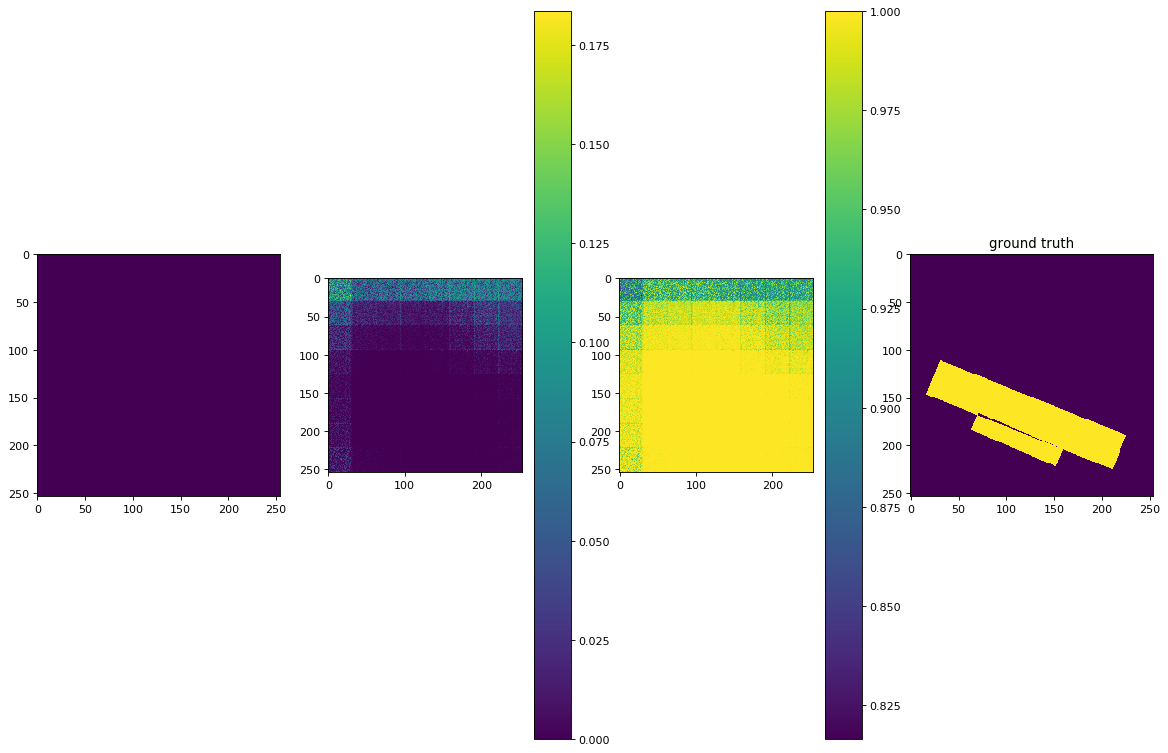

In [23]:
v_images, v_masks = next(val_iter)

outputs= model(v_images.to(device))
i = 0
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1,4,1)
plt.imshow(outputs.detach().cpu().numpy()[i,0,:,:] > outputs.detach().cpu().numpy()[i,1,:,:])

plt.subplot(1,4,2)
plt.imshow(outputs.detach().cpu()[i,0,:,:])
plt.colorbar()

plt.subplot(1,4,3)
plt.imshow(outputs.detach().cpu()[i,1,:,:])
plt.colorbar()

plt.subplot(1,4,4)
plt.imshow(v_masks.detach().cpu()[i,0,:,:])
plt.title('ground truth')

In [17]:
print(np.mean(outputs.detach().cpu().numpy()[0,1,:,:]))
print(np.mean(outputs.detach().cpu().numpy()[0,0,:,:]))

0.97273326
0.027266765


In [ ]:
print(outputs.detach().cpu().numpy()[0,0,:,:] < outputs.detach().cpu().numpy()[0,1,:,:])

In [ ]:
print(v_masks.shape)

In [ ]:
# plt.figure()
# max_idx = float(len(train_loader))
# plot_losses = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['losses']])
# plot_t_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['train_accs']])
# plot_v_a = np.array([(epoch + idx/max_idx, loss) for epoch, idx, loss in checkpoint_dict['val_accs']])
# plt.plot(plot_losses[:,0], plot_losses[:,1], label='loss')
# plt.plot(plot_t_a[:,0], 1- plot_t_a[:,1], label='train error')
# plt.plot(plot_v_a[:,0], 1- plot_v_a[:,1], label='val error')
# legend = plt.legend(loc='upper right')

In [ ]:
outputs.shape

In [ ]:
def check_checkpoint_file(path, max_len=30):
    checkpoint_dict = ASDC_loader.load_checkpoint(path)
    for key in checkpoint_dict:
        val_str = str(checkpoint_dict[key])
        print('{:s}: {:s}'.format(key, val_str[:max_len]))

# check_checkpoint_file('alex_net_test_params.pt.back')

print('-----------------')

check_checkpoint_file('alex_net_test_params.pt')

In [ ]:
loader_iter = iter(train_loader)
images, labels = loader_iter.next()

In [ ]:
model.remove_classifier()
print(model.features(images.to(device)).shape)
print(model.is_class)
print(model(images.to(device)).shape)

print(model(images.to(device)))


In [ ]:
outputs = model(images.to(device))
print(images.shape)
print(outputs.shape)

In [ ]:
param_path = './alex_net_class_params.pt'

save_whole_checkpoint()           
